In [1]:
from dotenv import load_dotenv
import os
from sqlalchemy import create_engine, text as sql_text

load_dotenv()

conn = create_engine(
    f"postgresql://{os.getenv('PG_USER')}:{os.getenv('PG_PASSWORD')}@{os.getenv('PG_HOST')}/{os.getenv('PG_DBNAME')}"
).connect()

In [2]:
import pandas as pd
 
temp_readings = pd.read_sql_query(sql_text("SELECT * FROM public.temp_readings"), conn)
fire_alerts = pd.read_sql_query(sql_text("SELECT * FROM public.fire_alerts"), conn)
tweets = pd.read_sql_query(sql_text("SELECT * FROM public.tweets"), conn)

In [ ]:
temp_readings

In [ ]:
tweets

In [ ]:
fire_alerts

# Experiment #1: Predicting fire alerts using temperature readings
Every sector at every day has a temperature reading, while only some sectors have messages. To start, we'll try to predict fire alerts on the day of using temperature readings only from the past 7 days.

In [3]:
from tqdm import tqdm

# create samples from the temperatures in X from the outputs in y
# the X has the temperature at a day index+1 (idx 0 = day 1)
# the y has the list of days that have fire alerts
# each sample should input 7 days, and output 1 or 0 for whether the 7th day has a fire alert
samples = []

for coord in tqdm(temp_readings['xy'].unique()):
    temp = temp_readings[temp_readings['xy'] == coord]
    fire = fire_alerts[fire_alerts['xy'] == coord]
    X = list(temp['temperature'])
    y = list(fire['event_day'])
    for i in range(7, len(X)):
        samples.append((X[i-7:i], 1 if i in y else 0))


100%|██████████| 900/900 [01:09<00:00, 12.94it/s]


In [4]:
import numpy as np

samples_x, samples_y = zip(*samples)
samples_x, samples_y = np.array(samples_x), np.array(samples_y)

len(samples_x)

2287799

In [ ]:
samples_x

In [ ]:
samples_y

In [5]:
from sklearn.model_selection import train_test_split

train_x, test_x, train_y, test_y = train_test_split(samples_x, samples_y, test_size=0.2)

In [ ]:
# plot distribution of samples
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.bar(['No Fire', 'Fire'], [len(train_y[train_y == 0]), len(train_y[train_y == 1])])
plt.title('Distribution of No Fire vs Fire Samples')
plt.xlabel('Sample Type')
plt.ylabel('Number of Samples')
plt.yscale('log')
plt.show()

In [ ]:
from imblearn.combine import SMOTEENN

# correct any imbalance before training
smoteenn = SMOTEENN()
train_x, train_y = smoteenn.fit_resample(train_x, train_y)

In [ ]:
# let's plot after fixing it now
plt.figure(figsize=(10, 5))
plt.bar(['No Fire', 'Fire'], [len(train_y[train_y == 0]), len(train_y[train_y == 1])])
plt.title('Distribution of No Fire vs Fire Samples')
plt.xlabel('Sample Type')
plt.ylabel('Number of Samples')
plt.yscale('log')
plt.show()

In [6]:
from sklearn.preprocessing import StandardScaler

# function to preprocess our data
def preprocess_train(x_data, y_data):
    x_scaler = StandardScaler()
    x_data = x_scaler.fit_transform(x_data)
    y_data = np.array(pd.get_dummies(y_data))
    return x_data, y_data, x_scaler

def preprocess_test(x_data, y_data, x_scaler):
    x_data = x_scaler.transform(x_data)
    y_data = np.array(pd.get_dummies(y_data))
    return x_data, y_data

In [7]:
train_x, train_y, scaler = preprocess_train(train_x, train_y)
test_x, test_y = preprocess_test(test_x, test_y, scaler)

In [ ]:
# save the scaler for future use
import pickle

with open('scaler.pkl', 'wb') as f:
    pickle.dump(scaler, f)

In [8]:
from keras import Sequential
from keras.layers import Dense, Dropout

# implement a simple neural network
def build_model(length_x):
    model = Sequential([
        Dense(512, activation='swish', input_shape=(length_x,)),
        Dropout(0.2),
        Dense(2, activation='softmax')
    ])
    
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

In [9]:
from keras.callbacks import EarlyStopping
callbacks = [
    EarlyStopping(
        # Stop training when `val_loss` is no longer improving
        monitor="val_loss",
        # "no longer improving" being defined as "no better than 1e-2 less"
        min_delta=1e-2,
        # "no longer improving" being further defined as "for at least 2 epochs"
        patience=5,
        verbose=1,
    )
]

dnn_model = build_model(len(samples_x[0]))

dnn_model.fit(
    train_x,
    train_y,
    epochs=100,
    callbacks=callbacks,
    batch_size=2048,
    validation_split=0.2,
    verbose=1,
)

2023-08-05 17:55:02.502233: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1
2023-08-05 17:55:02.502261: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2023-08-05 17:55:02.502267: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.33 GB
2023-08-05 17:55:02.502328: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:303] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-08-05 17:55:02.502550: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:269] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Epoch 1/100


2023-08-05 17:55:02.939064: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


512/715 [====================>.........] - ETA: 2s - loss: 0.0519 - accuracy: 0.9933

KeyboardInterrupt: 

In [ ]:
dnn_model.evaluate(test_x, test_y, batch_size=512, return_dict=True)

In [ ]:
# calculate the accuracy if we always predict [1, 0] to be the output
from sklearn.metrics import accuracy_score

accuracy_score(test_y, np.array([[1, 0]] * len(test_y)))

In [ ]:
# find the index of a [0, 1] example in the test y and predict it
idx = np.where(test_y == [0, 1])[0][0]
dnn_model.predict(test_x[idx:idx+1])

# Results
The model is able to be somewhat accurate, but this relies purely on temperature data. Before we move on to NLP and text analysis, let's try implementing an LSTM for this problem

# Experiment #2: Predicting fire alerts using temperature readings with an LSTM
The LSTM will take in the temperature readings from the past 7 days and output a prediction for the 7th day.

In [ ]:
lstm_train_x = train_x.reshape((train_x.shape[0], train_x.shape[1], 1))
lstm_test_x = test_x.reshape((test_x.shape[0], test_x.shape[1], 1))

In [ ]:
from keras.layers import LSTM

def build_lstm_model(length_x):
    model = Sequential([
        LSTM(50, activation='swish', input_shape=(length_x, 1)),
        Dense(2, activation='softmax')
    ])
    
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

In [ ]:
lstm_model = build_lstm_model(len(samples_x[0]))

lstm_model.fit(
    lstm_train_x,
    train_y,
    epochs=100,
    callbacks=callbacks,
    batch_size=4096,
    validation_split=0.2,
    verbose=1,
)

In [ ]:
lstm_model.evaluate(lstm_test_x, test_y, batch_size=4096, return_dict=True)

In [ ]:
np.where(test_y == [0, 1])[0][0]
lstm_model.predict(test_x[idx:idx+1])

In [ ]:
# save our two temperature models
dnn_model.save('dnn_model.h5')
lstm_model.save('lstm_model.h5')

# Experiment #3: Converting text to "temperature" data
We will try using sentiment analysis to convert text to "temperature" data (dubbed heat index).

In [10]:
# combine data from tweets and temperature
# merge the two DataFrames on 'day' and 'xy' columns
merged_df = tweets.merge(temp_readings, on=['day', 'xy'])

# get the desired 'content' and 'temperature' columns 
tweet_samples = merged_df[['content', 'temperature']].values.tolist()

tweet_samples

[['drew near the shore endeavoured to steer so that we might not strike and be capsized saw after few minutes that our conductor again wanted to',
  41],
 ['there we pulled easily by silver directions not to weary the hands prematurely and after quite long passage landed at the mouth of the second river that which runs down woody cleft',
  41],
 ['brush for it in earnest and looked to my priming captain said trelawney is the dead shot give him your gun his own is useless they exchanged guns and trelawney silent',
  41],
 ['him know as well as could the meaning of what read and he again by his serious inquiries and questionings made me as said before much better scholar in the scripture knowledge than should ever have been by my',
  41],
 ['called eagerly for help to the other but the captain stepping to him told him it was too late to',
  41],
 ['only we of the cabin party who perceived the danger long john was hard at work going from group to group spending himself in good advice and 

In [11]:
# now that we have our tweets and temperatures, let's try to train a sentiment analysis model to predict temperature from tweet content
# first, let's preprocess our data
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import nltk
import re
from tqdm import tqdm

# download the stopwords and lemmatizer
nltk.download('stopwords')
nltk.download('wordnet')

# initialize the lemmatizer
lemmatizer = WordNetLemmatizer()

# now, convert stopwords to set since lookup is faster in set
stopwords_set = set(stopwords.words('english'))

# then, modify the preprocess function
def preprocess_data(data):
    preprocessed_data = []
    for tweet in tqdm(data):
        tweet = re.sub('[^a-zA-Z0-9]', ' ', tweet)
        tweet = tweet.lower().split()
        # you can now check in set, which is faster than list
        tweet = [lemmatizer.lemmatize(word) for word in tweet if word not in stopwords_set]
        tweet = ' '.join(tweet)
        preprocessed_data.append(tweet)
    return preprocessed_data

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/alanalwakeel/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/alanalwakeel/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [12]:
# preprocess our data
preprocessed_tweets = preprocess_data([tweet[0] for tweet in tweet_samples])

100%|██████████| 1711163/1711163 [00:51<00:00, 33471.14it/s]


In [13]:
# now, let's try to train a sentiment analysis model
from sklearn.model_selection import train_test_split

# split our data into train and test sets
train_x, test_x, train_y, test_y = train_test_split(preprocessed_tweets, [tweet[1] for tweet in tweet_samples], test_size=0.2,)

In [14]:
# convert our data to a format that the model can understand
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

# initialize the tokenizer
print('Fitting tokenizer...')
tokenizer = Tokenizer(num_words=10000, oov_token='<OOV>')
tokenizer.fit_on_texts(train_x)

# convert our text to sequences
print('Converting text to sequences...')
train_sequences = tokenizer.texts_to_sequences(train_x)
test_sequences = tokenizer.texts_to_sequences(test_x)

# pad our sequences
print('Padding sequences...')
train_padded = pad_sequences(train_sequences, maxlen=100, padding='post', truncating='post')
test_padded = pad_sequences(test_sequences, maxlen=100, padding='post', truncating='post')

# scale our temperatures
print('Scaling temperatures...')
temperature_scaler = StandardScaler()
train_y = temperature_scaler.fit_transform(np.array(train_y).reshape(-1, 1))
test_y = temperature_scaler.transform(np.array(test_y).reshape(-1, 1))

Fitting tokenizer...
Converting text to sequences...
Padding sequences...
Scaling temperatures...


Text(0, 0.5, 'Frequency')

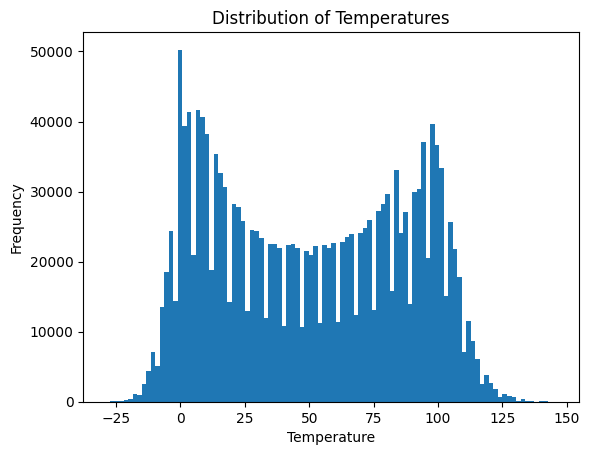

In [61]:
# plot the distribution of temperatures
plt.hist([tweet[1] for tweet in tweet_samples], bins=100)
plt.title('Distribution of Temperatures')
plt.xlabel('Temperature')
plt.ylabel('Frequency')

In [37]:
# save the temperature scaler
import pickle

with open('temperature_scaler.pkl', 'wb') as f:
    pickle.dump(temperature_scaler, f)

In [62]:
# build our model
from keras.layers import Embedding, GlobalAveragePooling1D
from keras.models import Sequential
from keras.metrics import RootMeanSquaredError
from keras.optimizers.legacy import Adam

def build_sentiment_model(lr=3e-5):
    model = Sequential([
        Embedding(10000, 16, input_length=100),
        GlobalAveragePooling1D(),
        Dense(16, activation='swish'),
        Dense(1, activation='linear')
    ])
    
    opt = Adam(learning_rate=lr)
    
    model.compile(optimizer=opt, loss='mse', metrics=['mae', RootMeanSquaredError('rmse')])
    return model

In [67]:
# train our model
sentiment_model = build_sentiment_model(lr=3e-7)

sentiment_model.fit(
    train_padded,
    train_y,
    epochs=100,
    callbacks=callbacks,
    batch_size=128,
    validation_split=0.2,
    verbose=1,
)

Epoch 1/100


2023-08-05 19:41:29.274509: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


 790/8556 [=>............................] - ETA: 7:40 - loss: 1.0010 - mae: 0.8881 - rmse: 1.0005

KeyboardInterrupt: 

In [35]:
sentiment_model.evaluate(test_padded, test_y, batch_size=64, return_dict=True)

5348/5348 [==============================] - 25s 5ms/step - loss: 0.9951 - mae: 0.8856 - rmse: 0.9975


{'loss': 0.9950617551803589,
 'mae': 0.8855599761009216,
 'rmse': 0.9975278377532959}

In [53]:
# try an example out
# pick a high heat index tweet
idx = np.where(test_y > 0)[0][0]
print(test_x[idx])

began cry aloud terror shout shout came others began run direction found treasure said old morgan


It is clear that the model is not performing well. This is because the temperature data is not linearly correlated with the sentiment of the tweet. We will try to use a different approach.

# Experiment #4: Using a pretrained sentiment analysis model
We will try to use a pretrained sentiment analysis model, BERT, to convert text to "temperature" data (dubbed heat index).

In [73]:
from keras import Input, Model
from transformers import TFBertModel, BertTokenizerFast

def build_bert_model():
    # initialize the tokenizer
    bert_tokenizer = BertTokenizerFast.from_pretrained('bert-base-uncased')
    
    # initialize the model
    bert_model = TFBertModel.from_pretrained('bert-base-uncased')
    
    # build the model
    input_ids = Input(shape=(100,), dtype='int32')
    attention_mask = Input(shape=(100,), dtype='int32')
    embedding = bert_model(input_ids, attention_mask=attention_mask)[0]
    embedding = GlobalAveragePooling1D()(embedding)
    embedding = Dense(16, activation='swish')(embedding)
    output = Dense(1, activation='linear')(embedding)
    
    model = Model(inputs=[input_ids, attention_mask], outputs=output)
    
    # freeze the bert model
    bert_model.trainable = False
    
    # compile the model
    model.compile(optimizer='adam', loss='mse', metrics=['mae', RootMeanSquaredError('rmse')])
    
    return model, bert_tokenizer

In [69]:
# build the model
bert_model, bert_tokenizer = build_bert_model()

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions w

In [70]:
# split our data into train and test sets
train_x, test_x, train_y, test_y = train_test_split(preprocessed_tweets, [tweet[1] for tweet in tweet_samples], test_size=0.2, )

In [72]:
# convert our data to a format that the BERT model can understand
# convert our text to sequences
print('Converting text to sequences...')
train_sequences = bert_tokenizer.batch_encode_plus(train_x, max_length=100, truncation=True, padding='max_length', return_tensors='tf')
test_sequences = bert_tokenizer.batch_encode_plus(test_x, max_length=100, truncation=True, padding='max_length', return_tensors='tf')

# scale our temperatures
print('Scaling temperatures...')
train_y = temperature_scaler.transform(np.array(train_y).reshape(-1, 1))
test_y = temperature_scaler.transform(np.array(test_y).reshape(-1, 1))

Converting text to sequences...
Scaling temperatures...


In [74]:
# train our model
bert_model.fit(
    [train_sequences['input_ids'], train_sequences['attention_mask']],
    train_y,
    epochs=100,
    callbacks=callbacks,
    batch_size=128,
    validation_split=0.2,
    verbose=1,
)

Epoch 1/100


2023-08-05 19:55:39.036721: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


   9/8556 [..............................] - ETA: 7:11:20 - loss: 1.0076 - mae: 0.8784 - rmse: 1.0038

KeyboardInterrupt: 

In [ ]:
bert_model.evaluate([test_sequences['input_ids'], test_sequences['attention_mask']], test_y, batch_size=64, return_dict=True)